# 1. PassportCard Insurance Claims PredictionThis project develops a machine learning system to predict future insurance claims for PassportCard policyholders.

## Setup and Installation

First, let's install the required packages:

In [5]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm jupyter scipy statsmodels plotly imbalanced-learn


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge

import xgboost as xgb
import scipy.stats as stats
import os
import warnings

# Configure visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## Data Loading

Let's load the claims and member data:

In [7]:
# Load claims data
claims_data = pd.read_csv('../claims_data_clean.csv')

# Display the first few rows
print(f"Claims data shape: {claims_data.shape}")
claims_data.head()

Claims data shape: (500, 9)


,ClaimNumber,TotPaymentUSD,ServiceDate,PayDate,ServiceGroup,ServiceType,Member_ID,PolicyID,Sex
0,1,111.103907,2021-03-07,2021-03-30,Outpatient,Medication,39,119,M
1,2,124.300275,2020-12-06,2020-12-24,Inpatient,Lab,29,114,M
2,3,104.620573,2021-07-04,2021-07-16,Preventive,Medication,15,107,M
3,4,1109.539920,2020-12-22,2021-01-04,Inpatient,Imaging,43,121,F
4,5,114.581081,2020-01-23,2020-02-18,Outpatient,Consultation,8,104,F


In [8]:
# Load member data
members_data = pd.read_csv('../members_data_clean.csv')

# Display the first few rows
print(f"Members data shape: {members_data.shape}")
members_data.head()

Members data shape: (50, 25)


,Member_ID,PolicyID,PolicyStartDate,PolicyEndDate,DateOfBirth,CountryOfOrigin,CountryOfDestination,Gender,BMI,Questionnaire_cancer,...,Questionnaire_liver,Questionnaire_immune,Questionnaire_tumor,Questionnaire_relatives,Questionnaire_alcoholism,Questionnaire_drink,uw_pct,average_us,average_ov,average_ob
0,1,100,2018-04-13,2021-01-13,1982-04-12,Germany,UK,False,20.052197,0,...,0,0,0,0,1,0,1.347262,0.307539,0.233027,0.299734
1,2,101,2018-12-15,2021-08-29,1954-06-14,UK,Germany,False,19.718174,0,...,0,0,0,0,0,0,0.598563,0.403754,0.690427,0.491540
2,3,101,2018-09-28,2021-12-11,1958-07-01,UK,Germany,True,27.087766,0,...,0,0,0,0,0,1,1.663291,0.572236,0.166239,0.276968
3,4,102,2018-04-17,2022-07-18,1941-02-15,France,Australia,False,26.187939,1,...,0,0,1,0,0,0,1.179933,0.314451,0.582522,0.890134
4,5,102,2018-03-13,2021-12-05,1978-05-07,Australia,Japan,True,26.001971,0,...,0,0,0,0,0,0,1.286585,0.599319,0.296279,0.855247


## Data Exploration and Cleaning

Let's explore the data and perform necessary cleaning.

In [9]:
# Convert date columns to datetime
claims_data['ServiceDate'] = pd.to_datetime(claims_data['ServiceDate'])
claims_data['PayDate'] = pd.to_datetime(claims_data['PayDate'])

# Display basic statistics
claims_data.describe()

,ClaimNumber,TotPaymentUSD,Member_ID,PolicyID
count,500.000000,500.000000,500.000000,500.00000
mean,250.500000,1181.822200,25.864000,112.68400
std,144.481833,1954.676251,14.315004,7.16623
min,1.000000,56.227311,1.000000,100.00000
25%,125.750000,144.288848,14.000000,107.00000
50%,250.500000,258.130176,26.000000,113.00000
75%,375.250000,845.084606,37.250000,118.25000
max,500.000000,7477.187581,50.000000,125.00000


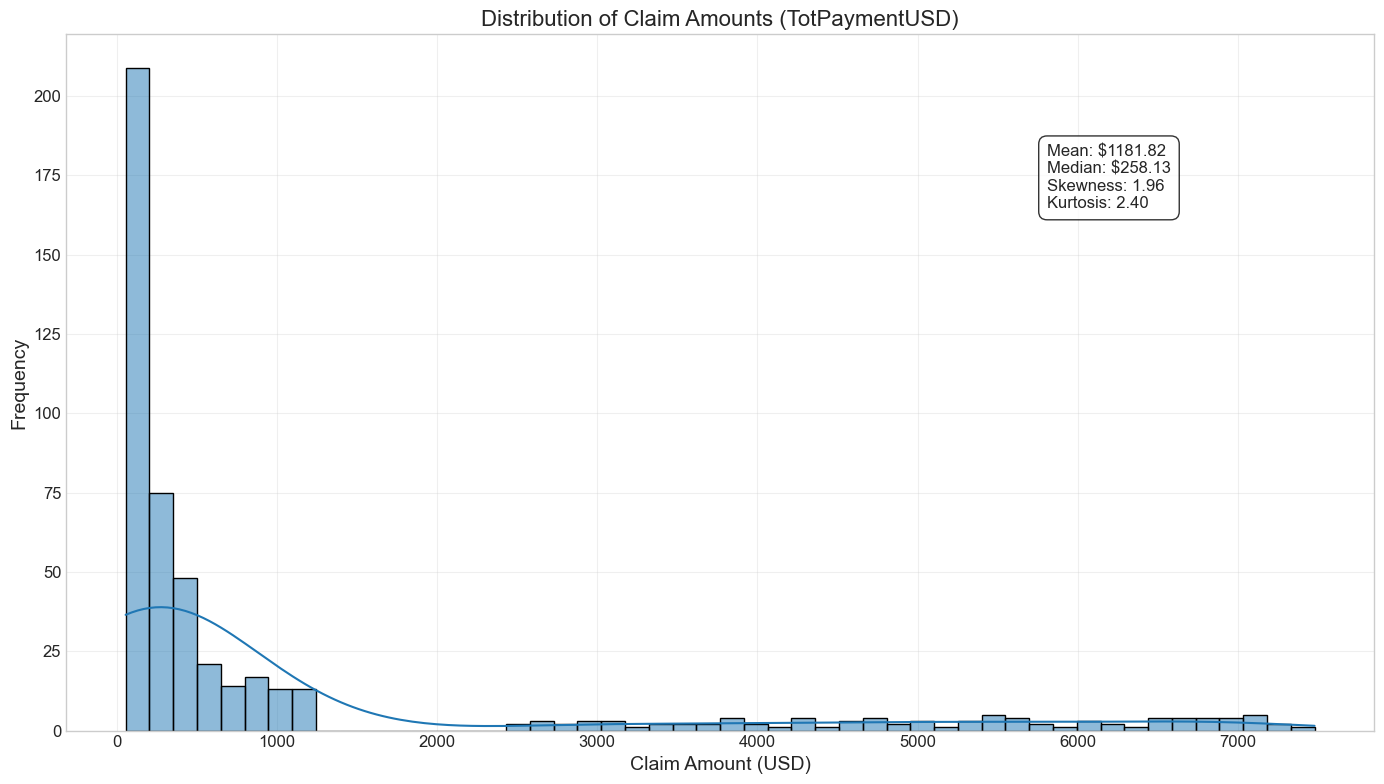

In [10]:
# Plot the distribution of claim amounts
plt.figure(figsize=(14, 8))

# Main plot - histogram with KDE
sns.histplot(claims_data['TotPaymentUSD'], kde=True, bins=50)
plt.title('Distribution of Claim Amounts (TotPaymentUSD)', fontsize=16)
plt.xlabel('Claim Amount (USD)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add statistical annotations
mean_val = claims_data['TotPaymentUSD'].mean()
median_val = claims_data['TotPaymentUSD'].median()
skew_val = claims_data['TotPaymentUSD'].skew()
kurtosis_val = claims_data['TotPaymentUSD'].kurtosis()

stats_text = f"Mean: ${mean_val:.2f}\nMedian: ${median_val:.2f}\nSkewness: {skew_val:.2f}\nKurtosis: {kurtosis_val:.2f}"
plt.annotate(stats_text, xy=(0.75, 0.75), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Missing Value Analysis and Data Cleaning

Let's analyze missing values and handle them appropriately.

In [11]:
def handle_missing_values(df, categorical_strategy='mode', numerical_strategy='knn'):
    """Advanced missing value handling with multiple strategies"""
    # Make a copy to avoid modifying the original
    df_processed = df.copy()
    
    # Get column types
    categorical_cols = df_processed.select_dtypes(include=['object', 'category']).columns
    numerical_cols = df_processed.select_dtypes(include=['int', 'float']).columns
    
    # Handle categorical features
    for col in categorical_cols:
        missing_count = df_processed[col].isna().sum()
        if missing_count > 0:
            print(f"Column {col}: {missing_count} missing values ({missing_count/len(df_processed)*100:.2f}%)")
            
            if categorical_strategy == 'mode':
                # Replace with mode
                mode_value = df_processed[col].mode()[0]
                df_processed[col].fillna(mode_value, inplace=True)
                print(f"  - Filled with mode: {mode_value}")
    
    # Handle numerical features
    if numerical_strategy == 'knn':
        # Check if there are any missing numerical values
        num_missing = df_processed[numerical_cols].isna().sum().sum()
        if num_missing > 0:
            print(f"Using KNN imputation for {num_missing} missing numerical values")
            
            # Use KNN imputation for numerical features
            numerical_data = df_processed[numerical_cols]
            
            # Handle infinite values before KNN imputation
            numerical_data = numerical_data.replace([np.inf, -np.inf], np.nan)
            
            # Initialize and fit the KNN imputer
            imputer = KNNImputer(n_neighbors=5)
            imputed_data = imputer.fit_transform(numerical_data)
            
            # Update the dataframe with imputed values
            df_processed[numerical_cols] = imputed_data
    
    return df_processed

# Apply the function to our datasets
claims_data_clean = handle_missing_values(claims_data)
members_data_clean = handle_missing_values(members_data)

# Verify that all missing values are handled
print("\nMissing values after imputation:")
print(f"Claims data: {claims_data_clean.isnull().sum().sum()}")
print(f"Members data: {members_data_clean.isnull().sum().sum()}")


Missing values after imputation:
Claims data: 0
Members data: 0
